In [60]:
import numpy as np
import pandas as pd
import scipy
from numba import jit

from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\miche\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Aux Functions

In [74]:
def frequencies_dict(kmeans, K, terms, cluster_index):
    centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    if cluster_index > K - 1:
        return
    term_frequencies = kmeans.cluster_centers_[cluster_index]
    sorted_terms = centroids[cluster_index]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return frequencies

In [75]:
def makeImage(frequencies, ax=None):
    wc = WordCloud(background_color="white", max_words=50)
    # generate word cloud
    wc.generate_from_frequencies(frequencies)

    # show
    if ax is not None:
        ax.imshow(wc, interpolation="bilinear")
        ax.axis('off')
    else:
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
    # plt.show()

# Load the Dataset

In [2]:
df = pd.read_csv('CleanDataset.csv').dropna()
cleans_reviews = df['reviewText'].str.replace(',',' ', regex=False).str.replace('.',' ', regex=False)

## Sample $500.000$ reviews at random

In [6]:
n_samples = 500_000
reviews = cleans_reviews.sample(n_samples).values

In [3]:
reviews = cleans_reviews.values

# Pre-processing
## Lemmatize the Dataset

In [4]:
def lemmatize_dataset(doc_array):
    lemmatizer = WordNetLemmatizer()
    # lemmatized_docs = np.full(doc_array.shape[0], '')
    for i, doc in tqdm(enumerate(doc_array)):
        word_list = word_tokenize(doc)
        lemmatized_doc = ""
        # lemmatized_doc = ' '.join(map(lemmatizer.lemmatize, word_list))
        for word in word_list:
            lemmatized_doc = lemmatized_doc + " " + lemmatizer.lemmatize(word)
        doc_array[i] = lemmatized_doc 
    return doc_array

In [7]:
lemmatized_reviews = lemmatize_dataset(reviews)

0it [00:00, ?it/s]

In [8]:
# docs_train, docs_test = train_test_split(lemmatized_reviews)
# docs_train.shape, docs_test.shape
docs_train = lemmatized_reviews

## Vectorize using all the words

In [85]:
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english')

In [86]:
%%time
X_train = vectorizer.fit_transform(docs_train)

Wall time: 49.7 s


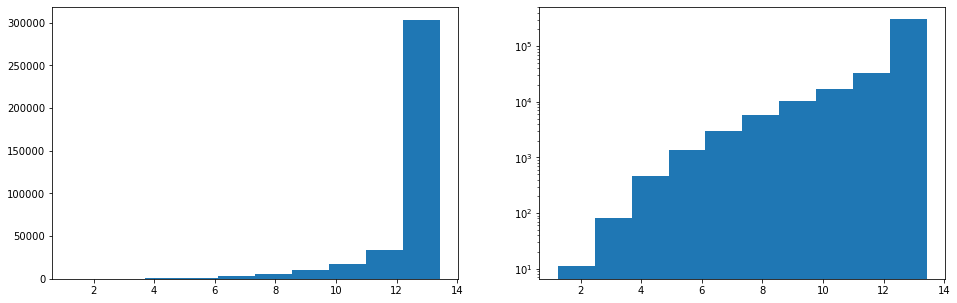

Total number of words: 375110


In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
ax_1, ax_2 = axs
ax_1.hist(vectorizer.idf_)
ax_2.hist(vectorizer.idf_)
ax_2.set_yscale('log')
plt.show()
print("Total number of words:", len(vectorizer.vocabulary_))

In [87]:
word_idf = dict(zip(vectorizer.vocabulary_.keys(), vectorizer.idf_[list(vectorizer.vocabulary_.values())]))

In [88]:
sorted(word_idf.items(), key=lambda x: x[1], reverse=False)[:20]

[('book', 1.2518665795843873),
 ('read', 1.7215033886144733),
 ('story', 1.9439414594682778),
 ('like', 2.1315363202282906),
 ('time', 2.2172086533609052),
 ('character', 2.241870528995608),
 ('good', 2.3170091329581157),
 ('author', 2.41486869008423),
 ('love', 2.442722807617189),
 ('life', 2.4551663830083057),
 ('great', 2.466769161267938),
 ('really', 2.470347759533233),
 ('reading', 2.4820674471231614),
 ('make', 2.4821114683766297),
 ('way', 2.4912303011053902),
 ('know', 2.641436383375267),
 ('thing', 2.7275705084806),
 ('people', 2.7954562866650265),
 ('year', 2.7979767440933525),
 ('think', 2.8016663611115886)]

In [89]:
sorted(word_idf.items(), key=lambda x: x[1], reverse=True)[:20]

[('undoctored', 13.429218196842383),
 ('noterority', 13.429218196842383),
 ('reviewerly', 13.429218196842383),
 ('revocably', 13.429218196842383),
 ('breedex', 13.429218196842383),
 ('poway', 13.429218196842383),
 ('mikeupdate', 13.429218196842383),
 ('againpeace', 13.429218196842383),
 ('foobar', 13.429218196842383),
 ('warez', 13.429218196842383),
 ('d00dz', 13.429218196842383),
 ('flipflop', 13.429218196842383),
 ('soccermom', 13.429218196842383),
 ('quiite', 13.429218196842383),
 ('logicall', 13.429218196842383),
 ('trindel', 13.429218196842383),
 ('vindicarns', 13.429218196842383),
 ('capative', 13.429218196842383),
 ('jannel', 13.429218196842383),
 ('studnets', 13.429218196842383)]

## Vectorize removing most and least common words
The word must appear in at least $0.5\%$ of the documents and at the most in $25\%$

In [90]:
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english',
                             min_df=.005, 
                             max_df=.25
                            )

In [91]:
%%time
X_train = vectorizer.fit_transform(docs_train)

Wall time: 44.3 s


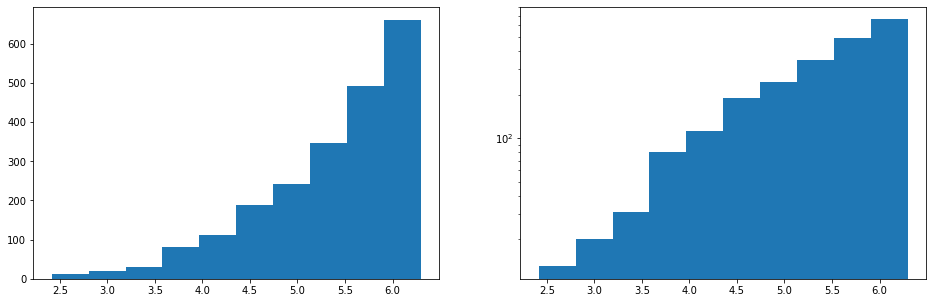

Total number of words: 2188


In [50]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
ax_1, ax_2 = axs
ax_1.hist(vectorizer.idf_)
ax_2.hist(vectorizer.idf_)
ax_2.set_yscale('log')
plt.show()
print("Total number of words:", len(vectorizer.vocabulary_))

In [92]:
word_idf = dict(zip(vectorizer.vocabulary_.keys(), vectorizer.idf_[list(vectorizer.vocabulary_.values())]))

In [93]:
sorted(word_idf.items(), key=lambda x: x[1], reverse=False)[:20]

[('author', 2.41486869008423),
 ('love', 2.442722807617189),
 ('life', 2.4551663830083057),
 ('great', 2.466769161267938),
 ('really', 2.470347759533233),
 ('reading', 2.4820674471231614),
 ('make', 2.4821114683766297),
 ('way', 2.4912303011053902),
 ('know', 2.641436383375267),
 ('thing', 2.7275705084806),
 ('people', 2.7954562866650265),
 ('year', 2.7979767440933525),
 ('think', 2.8016663611115886),
 ('want', 2.814105242500537),
 ('end', 2.8512185229155076),
 ('work', 2.855148653406458),
 ('new', 2.865055003893273),
 ('reader', 2.8962556935559234),
 ('written', 2.900608054168713),
 ('series', 2.911978464560563)]

In [94]:
sorted(word_idf.items(), key=lambda x: x[1], reverse=True)[:20]

[('wrap', 6.296321363883363),
 ('restaurant', 6.2959222419463154),
 ('attractive', 6.294725831035906),
 ('everybody', 6.294725831035906),
 ('holiday', 6.294725831035906),
 ('listed', 6.292734988252136),
 ('gospel', 6.292734988252136),
 ('kate', 6.292734988252136),
 ('revealing', 6.2919397595819975),
 ('distance', 6.291542382267013),
 ('amazed', 6.291542382267013),
 ('sensitive', 6.289161428761271),
 ('management', 6.288765153741225),
 ('compassion', 6.287577270014134),
 ('tedious', 6.287577270014134),
 ('deserve', 6.286786130732364),
 ('layer', 6.286786130732364),
 ('supposedly', 6.286786130732364),
 ('anecdote', 6.286786130732364),
 ('marketing', 6.286390795680763)]

# Clustering

In [54]:
%%time
k = 8
kmeans = MiniBatchKMeans(k, max_iter=100).fit(X_train)

Wall time: 12.7 s


In [55]:
kmeans.inertia_

476855.9618883284

In [56]:
centroids = kmeans.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
terms = vectorizer.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: love 8217 loved really romance want reading wait way author
Cluster 1: author really reading quot written way make page novel enjoyed
Cluster 2: series wait love reading really great loved enjoyed author end
Cluster 3: great really loved love author reading recommend wait enjoyed written
Cluster 4: history war american world people author year political state historical
Cluster 5: life woman family way novel people year make god child
Cluster 6: recipe cookbook food ingredient cooking cook easy delicious make great
Cluster 7: finish reading start really author page boring end plot great


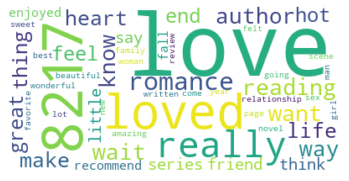

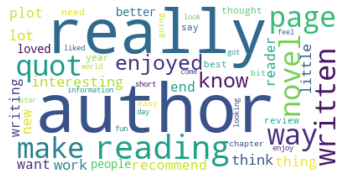

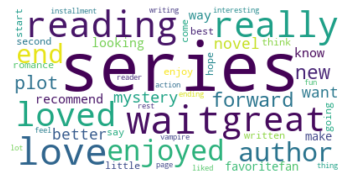

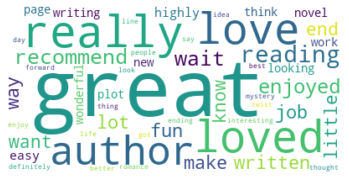

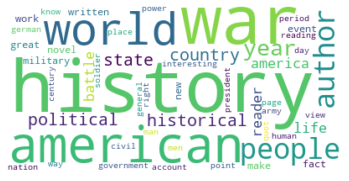

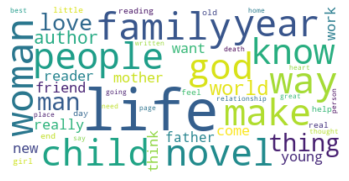

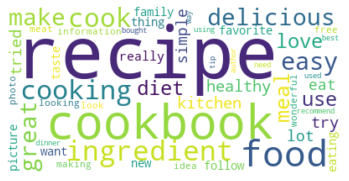

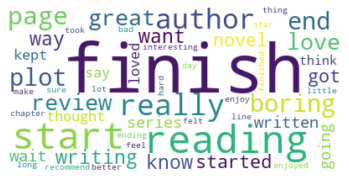

In [59]:
for i in range(k):
    freq = frequencies_dict(kmeans, k, terms, i)
    makeImage(freq)
    print()

## Find the optimal K

  0%|          | 0/5 [00:00<?, ?it/s]

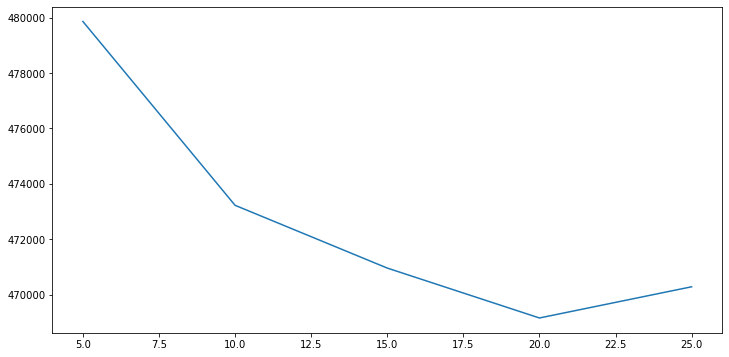

Wall time: 1min 9s


In [66]:
%%time

inertia = []
# silhouette_scores = []
cluster_sizes = list(range(4, 11, 2))
cluster_sizes = list(range(5, 26, 5))
for i in tqdm(cluster_sizes):
    kmeans = MiniBatchKMeans(i, max_iter=5).fit(X_train)
    inertia.append(kmeans.inertia_)
    # silhouette_scores.append(silhouette_score(X_train, 
    #                                           kmeans.labels_))
    
# fig, axs = plt.subplots(2, 1, figsize=(12, 7))
# ax1, ax2 = axs
plt.figure(figsize=(12, 6))
plt.plot(cluster_sizes, inertia)
plt.show()
# plt.plot(cluster_sizes, silhouette_scores)
# plt.show()

opt_K = cluster_sizes[np.argmin(inertia)]

## Fit a k-means using the optimal K

In [112]:
opt_K = 35
opt_kmeans = MiniBatchKMeans(opt_K).fit(X_train)

## Plot the results

In [113]:
centroids = opt_kmeans.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
terms = vectorizer.get_feature_names()
for i in range(opt_K):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: prefer nice table feature big includes section extensive pattern slightly
Cluster 1: detective 8217 killer partner victim right everybody department captain returned
Cluster 2: recipe magazine family accessible option cookbook article healthy appeal plenty
Cluster 3: kindle version reading free author great edition amazon bought really
Cluster 4: god christian jesus bible church life faith christ people way
Cluster 5: finish start reading really author great page end love want
Cluster 6: fought existence jack normal involved went kind felt bad sure
Cluster 7: interesting really author reading enjoyed plot written great lot thought
Cluster 8: recipe cookbook food ingredient cooking cook easy delicious great make
Cluster 9: life author great reading really way make know people work
Cluster 10: war history american world military people life author battle civil
Cluster 11: heaven finished reading bit corner fat passing wondered rescue pulled
Cluster 12: girl young church sex sl

0it [00:00, ?it/s]

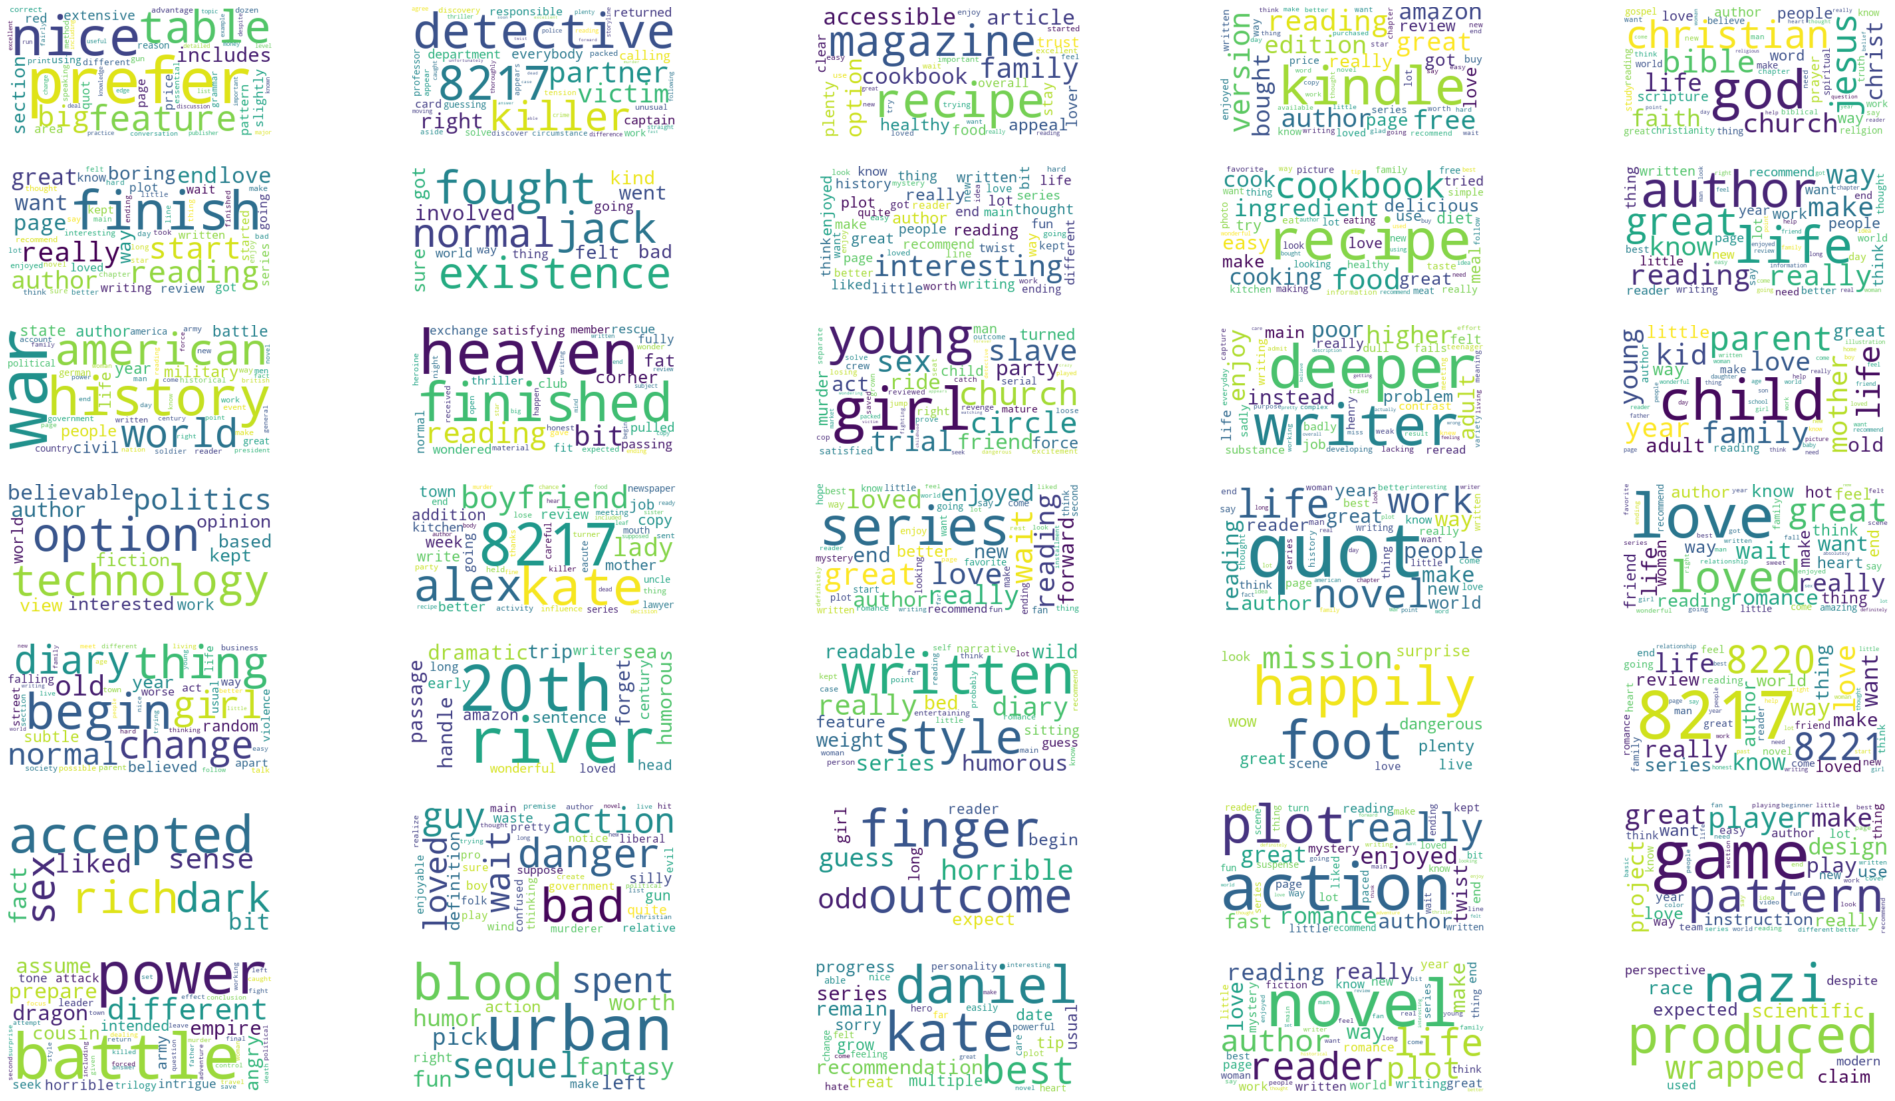

In [114]:
fig, axs = plt.subplots(opt_K//5, 5, figsize=(35, 20))
for i, ax in tqdm(enumerate(axs.flatten())):
    freq = frequencies_dict(opt_kmeans, opt_K, terms, i)
    makeImage(freq, ax)

___

## SVD

In [175]:
%%time
k=5
svd = TruncatedSVD(k)
# normalizer = Normalizer(copy=False)
# lsa = make_pipeline(svd, normalizer)
X_svd = svd.fit_transform(X_train)

Wall time: 441 ms


In [176]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    s = ""
    for t in sorted_terms:
        s += t[0] + " "
    print(s)

Topic 0: 
story character like love good time really author great life 
Topic 1: 
story series love character loved wait great enjoyed really romance 
Topic 2: 
quot series story character novel enjoyed wait reading great plot 
Topic 3: 
series love wait recipe loved great want quot know favorite 
Topic 4: 
love story life 8217 family woman loved man child heart 
